# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
	* [1.1 Problem statement](#1.1-Problem-statement)
* [2. Training CoNLL chunker](#2.-Training-CoNLL-chunker)
	* [2.1 Dataset](#2.1-Dataset)
	* [2.2 Attributes and features extraction](#2.2-Attributes-and-features-extraction)
	* [2.3 Models and optimization options](#2.3-Models-and-optimization-options)
* [3. Trained model evaluation](#3.-Trained-model-evaluation)
* [4. Using shallow parser/chunker (i.e. trained model)](#4.-Using-shallow-parser/chunker-%28i.e.-trained-model%29)
	* [4.1 Reviving trained model (chunker)](#4.1-Reviving-trained-model-%28chunker%29)
	* [4.2 Decoding method](#4.2-Decoding-method)


In [1]:
# first we define relevant directories
import sys
# in case PySeqLab package is not installed, 
# we can download the package repository from https://bitbucket.org/A_2/pyseqlab
# and then we add the location of the repository to the python system path
# location of the PySeqLab repository on disk -- INSERT location or discard if PySeqLab package is already installed
pyseqlab_package_dir = ""
sys.path.insert(0, pyseqlab_package_dir)
import os
# conll-chunker directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory under conll-chunker folder -- check the tree path (below)
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
tutorials_dir = os.path.join(project_dir, 'tutorials')
# to use for customizing the display/format of the cells
from IPython.core.display import HTML
with open(os.path.join(tutorials_dir, 'pseqlab_base.css')) as f:
    css = "".join(f.readlines())
HTML(css)


# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> the process/workflow for building CoNLL chunker (i.e. based on CRFs model formalism)</li>
<li> training the built model and evaluating its performance</li>
<li> reviving the trained model and decoding new sequences (i.e. test sequences that were not used for training)</li>
</ul>

## 1.1 Problem statement

As a <strong><em>reminder</em></strong>, the <a href="http://www.cnts.ua.ac.be/conll2000/chunking/">CoNLL 2000 task</a> states: <blockquote> Given a set of sentences (our sequences) where each sentence is composed of <span style="font-weight:bold;color:green;">words</span> and their corresponding <span style="font-weight:bold;color:green;">part-of-speech</span>, the goal is to predict the <span style="font-weight:bold;color:green;">chunk/shallow parse label</span> of every word in the sentence. </blockquote>

<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need first to clone the <a href="https://bitbucket.org/A_2/conll00-chunker">conll-chunker repository from bitbucket</a> to our disk locally. Then, navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder. The structure of the repository will be:
<pre style="font-size:0.8em;">
|---trained_models
|             |---2016_12_21-16_37_6_147704
|             |                        |---eval_model
|             |                        |         |---dec_trainseqs_fold_0.txt
|             |                        |         |---conlleval.pl
|             |                        |         |---decoded_test_beamsize_5.txt
|             |                        |         |---dec_testseqs.txt
|             |                        |---readme.rst
|             |                        |---crf_training_log.txt
|             |                        |---model_parts
|             |                        |          |---MR_L
|             |                        |          |---MR_modelfeatures
|             |                        |          |---MR_Ycodebook
|             |                        |          |---FE_templateY
|             |                        |          |---FE_templateX
|             |                        |          |---weights
|             |                        |          |---MR_modelfeaturescodebook
|---src
|    |---train_chunker_workflow.py
|    |---attr_extractor.py
|---tutorials
|        |---conll2000_chunker_tutorial.ipynb
|---README.rst
|---dataset
|      |---train_genia.txt
|      |---genia_treebank
|      |             |---train
|      |             |    |---train_genia.txt
|      |             |    |---train.pmids
|      |             |    |---future_use.pmids
|      |             |    |---dev.pmids
|      |             |    |---dev.trees
|      |             |    |---train.trees
|      |             |    |---future_use.trees
|      |             |---README
|      |             |---test
|      |             |    |---test_genia.txt
|      |             |    |---test.trees
|      |             |    |---test.pmids
|      |---conll2000
|      |        |---test.txt
|      |        |---train.txt
|      |---combined
|      |       |---test_conllgenia.txt
|      |       |---train_conllgenia.txt
|      |---test.txt
|      |---test_conllgenia.txt
|      |---test_genia.txt
|      |---train.txt
|      |---train_conllgenia.txt
</pre>

<strong><span style="color:red;">NB: </span></strong> <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> should be already installed or included in the python system path before we proceed.

# 2. Training CoNLL chunker

The <code class="pseq_code">src</code> directory in the cloned repository includes two main modules: 
<ul>
<li><code class="pseq_code">train_chunker_workflow.py </code></li>
<li><code class="pseq_code">attr_extractor.py </code></li>
</ul>

As a prerequisite, refer to <a href="http://pyseqlab.readthedocs.io/en/latest/methods_tutorials.html">the tutorials</a> describing in detail the model building and training process using PySeqLab package.

## 2.1 Dataset

In our current setting, our dataset is composed of two files found in the <code class="pseq_code">dataset</code> folder (see the printed tree path above):
<ol><li>training file (<code class="pseq_code">train.txt</code>) and </li><li> testing file (<code class="pseq_code">test.txt</code>)</li></ol>

## 2.2 Attributes and features extraction

We start first by defining out attribute extractor, which we will use to generate attributes from the parsed sequences. Our attribute extractor <code class="pseq_class">CONLL00_SeqAttributeExtractor</code> is subclass of <code class="pseq_class">GenericAttributeExtractor</code> class. It defines attributes based on the <code class="pseq_code">words and part-of-speech</code> at each position in the sequence. Below is <a href="#conll_attrext_demo">an example</a> of the attributes extracted using our <code class="pseq_class">CONLL00_SeqAttributeExtractor</code> class for the first sequence in our training file. 

After defining our attribute extractor, we define the feature templates that are used by the feature extractors to generate features. Feature templates and feature extraction are described in detail following <a href="http://pyseqlab.readthedocs.io/en/latest/_static/templates_and_features_extraction.html">this tutorial</a>.

In the <code class="pseq_code">train_chunker_workflow.py</code> module, we define our feature templates in <code class="pseq_function">template_config()</code> function.

<pre style="font-size:0.75em">
def template_config():
    template_generator = TemplateGenerator()
    templateXY = {}
    # generating template for w (i.e. word track)
    template_generator.generate_template_XY('w', ('1-gram', range(-2,3)), '1-state:2-states', templateXY)
    template_generator.generate_template_XY('w', ('2-gram', range(-1,2)), '1-state:2-states', templateXY)

    # generating template for pos (i.e. part-of-speech track)
    template_generator.generate_template_XY('pos', 
                                            ('1-gram:2-gram:3-gram', range(-2,3)), 
                                            '1-state:2-states', 
                                            templateXY)

    templateY = {'Y':()}
    return(templateXY, templateY)
</pre>

The defined templates include the two tracks (<code class="pseq_code">word and part-of-speech</code>). <br/>
For the <code class="pseq_code">word</code> track (i.e. attributes generated based on the words at each position in the sequence):
<ol>
<li>
<ul><li>We define a window of size 5 centered at each position in the sequence. That is, we pass through the sequence from left to right, where at each position, we construct a window of size 5 (a window that includes the two previous, current and two next attributes)</li>
<li>We extract unigrams (1-gram) in the specified window </li>
<li>We join these attributes with (1) the current state, and (2) the previous and current states (i.e. Y labels)</li>
</ul>
</li>
<br/>
<li>
<ul><li>We define a window of size 3 again centered at each position in the sequence where we extract bigrams in the defined window</li>
<li>We join these attributes with (1) the current state, and (2) the previous and current states (i.e. Y labels)</li>
</ul>
</li>
</ol>

For the <code class="pseq_code">part-of-speech</code> track:
<ol><li><ul><li>We define a window of size 5 centered at each position in the sequence. That is, we pass through the sequence from left to right, where at each position, we construct a window of size 5 (a window that includes the two previous, current and two next attributes)</li>
<li>We extract uigram, bigrams and trigrams in the specified window</li>
<li>We join these attributes with (1) the current state, and (2) the previous and current states (i.e. Y labels)</li></ul>
</li>
</ol>

## 2.3 Models and optimization options

Our defined feature templates use at most first order models (i.e models that use one and two states/labels at most). Therefore,  we will be using the <strong>first order</strong>:
<ul><li>feature extractor (<code class="pseq_class">FOFeatureExtractor)</code> subclass,</li>
<li>CRFs model (<code class="pseq_class">FirstOrderCRF</code>) and</li>
<li>CRFs model representation (<code class="pseq_class">FirstOrderCRFModelRepresentation</code>)</li>
</ul>

Finally, our training method (i.e. optimization options) will include:
<ul><li>stochastic gradient ascent (<code class="pseq_code">method = SGA</code>),</li>
<li>with l2 regularization (<code class="pseq_code">regularization_type = l2</code>) and regularization value equal to 1 (<code class="pseq_code">regularization_value = 1</code>), </li>
<li>and 10 passes through the training data (<code class="pseq_code">num_epochs = 10</code>)</li>
</ul>

To run the training process, we use <code class="pseq_function">run_training(optimization_options, template_config, train_fname, test_fname)</code> function. We pass the optimization options, feature templates and the name of the training and test files (<a href="#conll_trainmodel">see this code snippet</a>). The training process will perform the following:
<ol>
<li> read the training file (<code class="pseq_code">train.txt</code>) and parse it into sequences</li>
<li> process and dump the parsed sequences on disk in a relevant format to be later used in the learning framework </li>
<li> build a model based on the processed training sequences </li>
<li> train the model weights (i.e. estimate the feature weights) using the specified optimization method</li>
<li> use the trained model to decode the training sequences and write the result to a file</li>
<li> read the test file (<code class="pseq_code">test.txt</code>) parse it into sequences</li>
<li> use the trained model to decode the testing sequences and write the result to a file</li>
<li> return the path to the trained model directory </li>
</ol>

<a id="conll_attrext_demo"></a>

In [2]:
from attr_extractor import *
seq = example()

attr_desc {'w': {'description': 'the word/token', 'encoding': 'categorical', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <attr_extractor.CONLL00_SeqAttributeExtractor object at 0x104597550>>}, 'pos': {'description': 'the part-of-speech of the word', 'encoding': 'categorical', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <attr_extractor.CONLL00_SeqAttributeExtractor object at 0x104597550>>}}
boundary (16, 16)
attributes {'w': 'for', 'pos': 'IN'}
boundary (13, 13)
attributes {'w': 'if', 'pos': 'IN'}
boundary (6, 6)
attributes {'w': 'widely', 'pos': 'RB'}
boundary (20, 20)
attributes {'w': 'for', 'pos': 'IN'}
boundary (7, 7)
attributes {'w': 'expected', 'pos': 'VBN'}
boundary (27, 27)
attributes {'w': 'a', 'pos': 'DT'}
boundary (32, 32)
attributes {'w': 'and', 'pos': 'CC'}
boundary (11, 11)
attributes {'w': 'sharp', 'pos': 'JJ'}
boundary (5, 5)
attributes {'w': 'is', 'pos': 'VBZ'}
boundary (4, 4)
attributes {'w

<a id="conll_trainmodel"></a>

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
# import the module containing training workflow
# we use only 10 sequences for demonstration
# to go through the whole file simply omit passing the num_seqs keyword argument
num_seqs = 10
from train_chunker_workflow import *
optimization_options = {"method" : "SGA",
                        "regularization_type": "l2",
                        "regularization_value":1,
                        "num_epochs":10
                        }
train_fname = 'train.txt'
test_fname = 'test.txt'
# demonstrate training using only 10 sequences from the both the training and test file
res = run_training(optimization_options, template_config, train_fname, test_fname, num_seqs=10)

# using all sequences from the both the training and test file
# res = run_training(optimization_options, template_config, train_fname, test_fname)


1 sequences have been processed
2 sequences have been processed
3 sequences have been processed
4 sequences have been processed
5 sequences have been processed
6 sequences have been processed
7 sequences have been processed
8 sequences have been processed
9 sequences have been processed
10 sequences have been processed
dumping globalfeatures -- processed seqs:  1
dumping globalfeatures -- processed seqs:  2
dumping globalfeatures -- processed seqs:  3
dumping globalfeatures -- processed seqs:  4
dumping globalfeatures -- processed seqs:  5
dumping globalfeatures -- processed seqs:  6
dumping globalfeatures -- processed seqs:  7
dumping globalfeatures -- processed seqs:  8
dumping globalfeatures -- processed seqs:  9
dumping globalfeatures -- processed seqs:  10
constructing model -- processed seqs:  1
constructing model -- processed seqs:  2
constructing model -- processed seqs:  3
constructing model -- processed seqs:  4
constructing model -- processed seqs:  5
constructing model -- p

# 3. Trained model evaluation

To evaluate the performance of the trained model, we will use the <code class="pseq_code">conleval.pl</code> script provided by the CoNLL task organizers. The returned directory for the trained model will have the following structure:

<pre style="font-size:0.8em;">
├── avg_loglikelihood_training
├── crf_training_log.txt
├── decoding_seqs
│   ├── test_fold_0.txt
│   ├── train_fold_0.txt
├── model_parts
│   ├── class_desc.txt
│   ├── FE_templateX
│   ├── FE_templateY
│   ├── MR_L
│   ├── MR_modelfeatures
│   ├── MR_modelfeaturescodebook
│   ├── MR_Ycodebook
│   ├── weights
</pre>

The main parts of the model are found under the <code class="pseq_code">model_parts</code> folder. The decoded sequences using the trained model are found under <code class="pseq_code">decoding_seqs</code> folder. In that folder, we have the decoding of the training and test files. We evaluate the performance of the trained model by passing those files to the <code class="pseq_code">conleval.pl</code> script (<a href="#conll_evalmodel">as in this code snippet</a>). We also plot the estimated average log-likelihood during the training epochs using <code class="pseq_code">avg_loglikelihood_training</code> file. It serves as diagnostics for the learning process.


<a id="conll_evalmodel"></a>

processed 312 tokens with 146 phrases; found: 146 phrases; correct: 146.
accuracy: 100.00%; precision: 100.00%; recall: 100.00%; FB1: 100.00
             ADJP: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
             ADVP: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
               NP: precision: 100.00%; recall: 100.00%; FB1: 100.00  78
               PP: precision: 100.00%; recall: 100.00%; FB1: 100.00  33
             SBAR: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
               VP: precision: 100.00%; recall: 100.00%; FB1: 100.00  26
processed 215 tokens with 98 phrases; found: 94 phrases; correct: 68.
accuracy:  84.19%; precision:  72.34%; recall:  69.39%; FB1:  70.83
             ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:  71.88%; recall:  79.31%; FB1:  75.41  64
               PP: precision:  85.00%; recall:  89.47%; FB1:  87.18  20
             SBAR: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
      

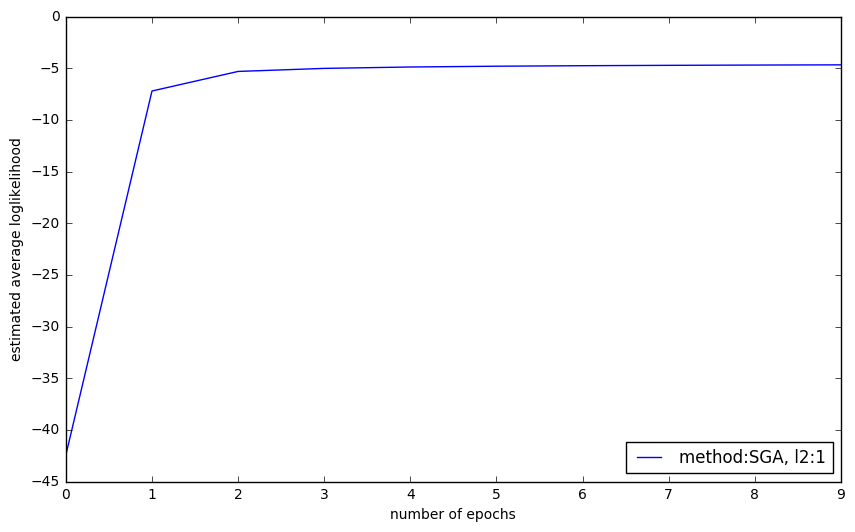

In [4]:
model_dir = res[0]
# evaluate model on the training data
decoded_training_file = os.path.join(model_dir, 'decoding_seqs', 'train_fold_0.txt')
!./conlleval.pl -d ' ' < $decoded_training_file
# evaluate model on test data set
decoded_test_file = os.path.join(model_dir, 'decoding_seqs', 'test_fold_0.txt')
!./conlleval.pl -d ' ' < $decoded_test_file
# plot the estimated average loglikelihood
avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_loglikelihood_training'))
plt.plot(avg_ll[1:], label="method:{}, {}:{}".format(optimization_options['method'], 
                                                     optimization_options['regularization_type'],
                                                     optimization_options['regularization_value']))
plt.legend(loc='lower right')
plt.xlabel('number of epochs')
plt.ylabel('estimated average loglikelihood')

# 4. Using shallow parser/chunker (i.e. trained model)

In this section, we demonstrate how to revive a previously trained model for chunking/shallow parsing using <a href="http://www.cnts.ua.ac.be/conll2000/chunking/">CoNLL 2000 dataset</a>.
<br/>
As a reminder, the trained model (including its components) are found under <code class="pseq_code">trained_models </code>folder that has the following structure:
<pre style="font-size:0.8em;">
|---trained_models
|             |---2016_12_21-16_37_6_147704
|             |                        |---eval_model
|             |                        |         |---dec_trainseqs_fold_0.txt
|             |                        |         |---conlleval.pl
|             |                        |         |---decoded_test_beamsize_5.txt
|             |                        |         |---dec_testseqs.txt
|             |                        |---readme.rst
|             |                        |---crf_training_log.txt
|             |                        |---model_parts
|             |                        |          |---MR_L
|             |                        |          |---MR_modelfeatures
|             |                        |          |---MR_Ycodebook
|             |                        |          |---FE_templateY
|             |                        |          |---FE_templateX
|             |                        |          |---weights
|             |                        |          |---MR_modelfeaturescodebook
</pre>

## 4.1 Reviving trained model (chunker)

To use/revive our trained model we use <code class="pseq_function">revive_learnedmodel(args)</code> function that takes the path/directory to the trained model. Looking again to the directory tree:
<pre style="font-size:0.8em;">
|---trained_models
|             |---2016_12_21-16_37_6_147704
|             |                        |---eval_model
|             |                        |         |---dec_trainseqs_fold_0.txt
|             |                        |         |---conlleval.pl
|             |                        |         |---decoded_test_beamsize_5.txt
|             |                        |         |---dec_testseqs.txt
|             |                        |---readme.rst
|             |                        |---crf_training_log.txt
|             |                        |---model_parts
|             |                        |          |---MR_L
|             |                        |          |---MR_modelfeatures
|             |                        |          |---MR_Ycodebook
|             |                        |          |---FE_templateY
|             |                        |          |---FE_templateX
|             |                        |          |---weights
|             |                        |          |---MR_modelfeaturescodebook
</pre>
The folder <code class="pseq_code">2016_12_21-16_37_6_147704</code> under <code class="pseq_code">trained_models</code> folder represents the path to our trained model.

In [6]:
# we get the trained model parts directory -- check the tree path in the cell above
trained_model_dir = os.path.join(project_dir, 'trained_models')
# loading the trained model
crf_m = revive_learnedmodel(os.path.join(trained_model_dir, '2016_12_21-16_37_6_147704'))

After we have revived our model, we need sentences to decode. We will use the test dataset provided by the
CoNLL task under the dataset directory. Just as a reminder, the tree path is:
<pre style="font-size:0.8em;">
|---dataset
|      |---train_genia.txt
|      |---genia_treebank
|      |             |---train
|      |             |    |---train_genia.txt
|      |             |    |---train.pmids
|      |             |    |---future_use.pmids
|      |             |    |---dev.pmids
|      |             |    |---dev.trees
|      |             |    |---train.trees
|      |             |    |---future_use.trees
|      |             |---README
|      |             |---test
|      |             |    |---test_genia.txt
|      |             |    |---test.trees
|      |             |    |---test.pmids
|      |---conll2000
|      |        |---test.txt
|      |        |---train.txt
|      |---combined
|      |       |---test_conllgenia.txt
|      |       |---train_conllgenia.txt
|      |---test.txt
|      |---test_conllgenia.txt
|      |---test_genia.txt
|      |---train.txt
|      |---train_conllgenia.txt
</pre>

The test dataset is composed of multiple sentences that are separated by a newline. The words in every sentence are laid each on a separate line with additional information such as their part-of-speech. The last column is dedicated for the chunk label which is our task to predict. The first two sentences in the file are provided below:
<pre style="font-size:0.8em;">
w pos chunk
Rockwell NNP B-NP
International NNP I-NP
Corp. NNP I-NP
's POS B-NP
Tulsa NNP I-NP
unit NN I-NP
said VBD B-VP
it PRP B-NP
signed VBD B-VP
a DT B-NP
tentative JJ I-NP
agreement NN I-NP
extending VBG B-VP
its PRP$ B-NP
contract NN I-NP
with IN B-PP
Boeing NNP B-NP
Co. NNP I-NP
to TO B-VP
provide VB I-VP
structural JJ B-NP
parts NNS I-NP
for IN B-PP
Boeing NNP B-NP
's POS B-NP
747 CD I-NP
jetliners NNS I-NP
. . O

Rockwell NNP B-NP
said VBD B-VP
the DT B-NP
agreement NN I-NP
calls VBZ B-VP
for IN B-SBAR
it PRP B-NP
to TO B-VP
supply VB I-VP
200 CD B-NP
additional JJ I-NP
so-called JJ I-NP
shipsets NNS I-NP
for IN B-PP
the DT B-NP
planes NNS I-NP
. . O
</pre>

To read the file, we will use <code class="pseq_class">DataFileParser</code> class in the <code class="pseq_code">utilities</code> module. 

In [8]:
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = "main"
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the words/observations
column_sep = " "
seqs = []
for seq in dparser.read_file(os.path.join(project_dir, 'dataset', 'test.txt'), header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
    
# printing one sequence for display
print(seqs[0])
print("number of parsed sequences is: ", len(seqs))

Y sequence:
 ['B-NP', 'I-NP', 'I-NP', 'B-NP', 'I-NP', 'I-NP', 'B-VP', 'B-NP', 'B-VP', 'B-NP', 'I-NP', 'I-NP', 'B-VP', 'B-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'B-NP', 'I-NP', 'B-PP', 'B-NP', 'B-NP', 'I-NP', 'I-NP', 'O']
X sequence:
 {1: {'w': 'Rockwell', 'pos': 'NNP'}, 2: {'w': 'International', 'pos': 'NNP'}, 3: {'w': 'Corp.', 'pos': 'NNP'}, 4: {'w': "'s", 'pos': 'POS'}, 5: {'w': 'Tulsa', 'pos': 'NNP'}, 6: {'w': 'unit', 'pos': 'NN'}, 7: {'w': 'said', 'pos': 'VBD'}, 8: {'w': 'it', 'pos': 'PRP'}, 9: {'w': 'signed', 'pos': 'VBD'}, 10: {'w': 'a', 'pos': 'DT'}, 11: {'w': 'tentative', 'pos': 'JJ'}, 12: {'w': 'agreement', 'pos': 'NN'}, 13: {'w': 'extending', 'pos': 'VBG'}, 14: {'w': 'its', 'pos': 'PRP$'}, 15: {'w': 'contract', 'pos': 'NN'}, 16: {'w': 'with', 'pos': 'IN'}, 17: {'w': 'Boeing', 'pos': 'NNP'}, 18: {'w': 'Co.', 'pos': 'NNP'}, 19: {'w': 'to', 'pos': 'TO'}, 20: {'w': 'provide', 'pos': 'VB'}, 21: {'w': 'structural', 'pos': 'JJ'}, 22: {'w': 'parts', 'pos': 'NNS'}, 23: {

## 4.2 Decoding method

Then, we decide the decoding options for our model to use. The main method for decoding is <code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments. 
<br/>

The obligatory arguments are:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string representing the decoding method such as <code class="pseq_code">'viterbi'</code>
</li>
<li>
<code class="pseq_args">output_dir</code>: string, the output directory representing the path where the parsing would take place
</li>
</ol>

For the keyword arguments, the main ones to specify are:
<ul>
<li>
<code class="pseq_args">seqs</code>: the list of sequences we already parsed/read from the text file we need to label
</li>
<li>
<code class="pseq_args">file_name</code>: the name of the file where decoded sequences will be written to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: the separator between the columns/observations when writing decoded sequences to the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

In [9]:
decoding_method = 'viterbi'
output_dir = os.path.join(project_dir, 'tutorials')
sep = "\t"
# decode sequences
seqs_decoded = crf_m.decode_seqs(decoding_method, output_dir, seqs= seqs, file_name = 'tutorial_seqs_decoding.txt', sep=sep)

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
identifying model active features -- processed seqs:  5
identifying model active features -- processed seqs:  6
identifying model active features -- processed seqs:  7
identifying model active features -- processed seqs:  8
identifying model active features -- processed seqs:  9
identifying model active features -- processed seqs:  10
identifying model active features -- processed seqs:  11
identifying model active features -- processed seqs:  12
identifying model active features -- processed seqs:  13
identifying model active features -- processed seqs:  14
identifying model active features -- processed seqs:  15
identifying model active features -- processed seqs:  16
identifying model active features -- processed seqs:  17
identifying model active features -- pro

The decoded sequences will be found under the <code class="pseq_code">tutorials</code> directory (i.e. current directory) under <code class="pseq_code">decoding_seqs</code> folder.
<pre style="font-size:0.8em;">
|---tutorials
|      |---decoding_seqs
|      |             |---tutorial_seqs_decoding.txt
</pre>
The <code class="pseq_code">tutorial_seqs_decoding.txt</code> file will follow the same template/format of the <code class="pseq_code">test.txt</code> file we already parsed earlier, but this time with additional column that contains our model's predictions.
We can check our model performance by using <code class="pseq_code">conleval.pl</code> script provided by the CoNLL organizers. 

In [12]:
new_decseqs_file = os.path.join(tutorials_dir, 'decoding_seqs','tutorial_seqs_decoding.txt')
! ./conlleval.pl -d '\t' < $new_decseqs_file

processed 47377 tokens with 23852 phrases; found: 23791 phrases; correct: 22312.
accuracy:  95.98%; precision:  93.78%; recall:  93.54%; FB1:  93.66
             ADJP: precision:  79.10%; recall:  72.60%; FB1:  75.71  402
             ADVP: precision:  82.19%; recall:  80.48%; FB1:  81.33  848
            CONJP: precision:  71.43%; recall:  55.56%; FB1:  62.50  7
             INTJ: precision: 100.00%; recall:  50.00%; FB1:  66.67  1
              LST: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:  94.26%; recall:  93.95%; FB1:  94.11  12380
               PP: precision:  96.91%; recall:  97.80%; FB1:  97.35  4855
              PRT: precision:  80.81%; recall:  75.47%; FB1:  78.05  99
             SBAR: precision:  88.87%; recall:  85.05%; FB1:  86.91  512
               VP: precision:  93.47%; recall:  94.05%; FB1:  93.76  4687


Our model achieves overall F1-measure equal to 93.66% <br/>

OK, can we do better? Well, to answer this question, we need to explore and experiment with different feature templates and attributes for training a model. We leave this as an exercise for the readers ... :)
